# Segment Ranking for Lake County TSM&O Master Plan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.style.use('bmh')
plt.rcParams['font.family'] = 'calibri'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 18

"""Input and Output Directories and Files"""
IMPORT_DIR = "C:\Users\Alex\Documents\Jupyter Notebooks\Lake County ITS MP"
IMPORT_FILE = "Lake County TMS Segment Report_2014.xlsx"
CRASH_DATA_2014 = "2014_CrashSegments.xlsx"
CRASH_DATA_2015 = "2015_CrashSegments.xlsx"
MANUAL_SEG_LEN = "Manual Segment Length.xlsx"
MANUAL_CRASH_DATA = "2014_2015 Manual Crash Data.xlsx"
CONSTRAINED_CORR = "MaxLaneConstrainedCorridors.xlsx"
# CRASH_DATA_2016 = "2016_CrashSegments.xlsx"
SAVE_DIR = "C:\Users\Alex\Documents\Jupyter Notebooks\Lake County ITS MP"
SAVE_FILE_ALL = "Scored Segments_ALL.xlsx"
SAVE_FILE_REG = "Scored Segments_REG.xlsx"
SAVE_FILE_NONREG = "Scored Segments_NONREG.xlsx"
SAVE_FILE_SIS = "Scored Segments_SIS.xlsx"
SAVE_FILE_NONSIS = "Scored Segments_NONSIS.xlsx"
SAVE_FILE_CONSTR = "Scored Segments_CONSTRAINED.xlsx"


## Data Importing and Clean-Up

### Traffic and Roadway Data

Use the Lake County Roadway Inventory - 2014 table provided in the "2014 Lake-Sumpter MPO - Transportation Management System Annual Report." Import table data as a pandas data, and add a few useful columns.


In [2]:
#Import the excel data as pandas dataframe
lcri2014 = pd.read_excel(open(os.path.join(IMPORT_DIR,IMPORT_FILE), 'rb'), 
                         sheetname = "Table 1", skiprows = 1, index_col = 0)

#Rename repeat columns based on direction
lcri2014.rename(columns={'RESERVED': 'EB/NB RESERVED'}, inplace = True)
lcri2014.rename(columns={'TOTAL': 'EB/NB TOTAL'}, inplace = True)
lcri2014.rename(columns={'LOS': 'EB/NB LOS'}, inplace = True)
lcri2014.rename(columns={'V/C RATIO': 'EB/NB VC RATIO'}, inplace = True)
lcri2014.rename(columns={'RESERVED.1': 'WB/SB RESERVED'}, inplace = True)
lcri2014.rename(columns={'TOTAL.1': 'WB/SB TOTAL'}, inplace = True)
lcri2014.rename(columns={'LOS.1': 'WB/SB LOS'}, inplace = True)
lcri2014.rename(columns={'V/C RATIO.1': 'WB/SB VC RATIO'}, inplace = True)

#Create average V/C ratio column using EB/NB and WB/SB V/C ratios
lcri2014['VC RATIO AVG'] = (lcri2014['WB/SB VC RATIO'] + lcri2014['EB/NB VC RATIO']) / 2

#Create maximum V/C ratio column
lcri2014['MAX VC RATIO'] = lcri2014[['WB/SB VC RATIO', 'EB/NB VC RATIO']].max(axis=1)

lcri2014.index.name = "SEGMENT_ID"

lcri2014.head()


,ROAD NAME,FROM,TO,NUMBER OF LANES,AREA TYPE,MAINTAINING AGENCY,JURISDICTION,FUNCTIONAL CLASSIFICATION,FDOT LOS STANDARD,LOS CAPACITY,...,WB/SB,WB/SB RESERVED,WB/SB TOTAL,WB/SB VC RATIO,WB/SB LOS,PLANNED ACTIVITY?,HURRICANE ROUTE?,TRANSIT ROUTES,VC RATIO AVG,MAX VC RATIO
SEGMENT_ID,,,,,,,,,,,,,,,,,,,,,
10,ABRAMS ROAD,SR 44,WAYCROSS AVENUE,2,U,COUNTY,CITY OF EUSTIS,COLLECTOR,D,675,...,178.0,0.0,178.0,0.26,C,N,N,0,0.280,0.30
20,ANDERSON HILL ROAD,LAKE SHORE DRIVE,US 27,2,U,COUNTY,UNINCORPORATED LAKE COUNTY,COLLECTOR,D,675,...,42.0,0.0,42.0,0.06,C,N,N,0,0.105,0.15
30,ARDICE AVENUE,KURT STREET,SR 19,2,U,CITY OF EUSTIS,CITY OF EUSTIS,COLLECTOR,D,675,...,212.0,0.0,212.0,0.31,C,N,N,1,0.315,0.32
40,ARLINGTON AVENUE,W LADY LAKE BOULEVARD,SOUTH TERMINI,2,U,COUNTY,TOWN OF LADY LAKE,COLLECTOR,D,675,...,62.0,0.0,62.0,0.09,C,N,N,0,0.095,0.10
50,AUSTIN MERRITT ROAD,YOUTH CAMP ROAD,CR 33,2,R,COUNTY,UNINCORPORATED LAKE COUNTY,COLLECTOR,C,603,...,30.0,0.0,30.0,0.05,C,N,N,0,0.080,0.11


### Crash Data

Use crash data provided by Lake-Sumter MPO using GIS tools to assign crashes per segment.

In [3]:
#Import Crash Data Excel files as Dataframes
crash2014 = pd.read_excel(open(os.path.join(IMPORT_DIR,CRASH_DATA_2014), 'rb'),
                          sheetname = "2014CrashData2TMS_Join20170124")
crash2015 = pd.read_excel(open(os.path.join(IMPORT_DIR,CRASH_DATA_2015), 'rb'),
                          sheetname = "2015CrashData2TMS_Join20170124v")

#Import missing manually determined segment lengths
manSegLen = pd.read_excel(open(os.path.join(IMPORT_DIR,MANUAL_SEG_LEN), 'rb'),
                          sheetname = 'Sheet1', index_col=0)

#Import missing manually determined 2014 & 2015 crash data
manCrash = pd.read_excel(open(os.path.join(IMPORT_DIR, MANUAL_CRASH_DATA), 'rb'), 
                         sheetname = 'All', index_col=0)

#Group by segment_ID to be matched with Traffic and Roadway Data
grouped2014 = crash2014.groupby(['SEGMENT_ID'])
grouped2015 = crash2015.groupby(['SEGMENT_ID'])

#Determine number of crashes per segment by counting columns
crashCounts2014 = grouped2014.size().to_frame()
crashCounts2014.columns = ['2014 CRASHES']
crashCounts2015 = grouped2015.size().to_frame()
crashCounts2015.columns = ['2015 CRASHES']

#Determine length of segments from crash data
#Find segment length from first occurence
links2014 = crash2014.groupby(['LINK_ID']).aggregate('first') 
links2015 = crash2015.groupby(['LINK_ID']).aggregate('first')

#Sum link lengths to find segment lengths use 2014 segments for all analysis
seg2014 = links2014.groupby(['SEGMENT_ID'])[['LINK_LENGT']].aggregate(np.sum)
seg2014.columns = ['SEGMENT LENGTH']
seg2015 = links2015.groupby(['SEGMENT_ID'])[['LINK_LENGT']].aggregate(np.sum)
seg2015.columns = ['SEGMENT LENGTH']

#Merge length and crashcounts data frames for the respective years
crashes2014_2015 = pd.concat([crashCounts2014, crashCounts2015], axis=1)
crashCountLen = pd.concat([crashes2014_2015, seg2014], axis=1, join='outer')
     
# Concatenate Dataframes to add crash data and segment lengths
lcri2014 = pd.concat([lcri2014, crashCountLen], axis=1)

# Fill in missing 2014 segment length data with 2015 segment lengths data from crash2015
lcri2014['SEGMENT LENGTH'].fillna(seg2015['SEGMENT LENGTH'], inplace=True)

# Fill rest of missing segment length data with manually determined lengths
lcri2014['SEGMENT LENGTH'].fillna(manSegLen['SEGMENT LENGTH'], inplace=True)

# Fill in missing 2014 and 2015 crash data with manually collected data
lcri2014['2014 CRASHES'].fillna(manCrash['2014 CRASHES'], inplace=True)
lcri2014['2015 CRASHES'].fillna(manCrash['2015 CRASHES'], inplace=True)

lcri2014.head()

# #Aggregate sum crash data per segment_ID
# crashAgg2014 = grouped2014.aggregate(np.sum)
# crashAgg2015 = grouped2015.aggregate(np.sum)

,ROAD NAME,FROM,TO,NUMBER OF LANES,AREA TYPE,MAINTAINING AGENCY,JURISDICTION,FUNCTIONAL CLASSIFICATION,FDOT LOS STANDARD,LOS CAPACITY,...,WB/SB VC RATIO,WB/SB LOS,PLANNED ACTIVITY?,HURRICANE ROUTE?,TRANSIT ROUTES,VC RATIO AVG,MAX VC RATIO,2014 CRASHES,2015 CRASHES,SEGMENT LENGTH
SEGMENT_ID,,,,,,,,,,,,,,,,,,,,,
10,ABRAMS ROAD,SR 44,WAYCROSS AVENUE,2.0,U,COUNTY,CITY OF EUSTIS,COLLECTOR,D,675.0,...,0.26,C,N,N,0.0,0.280,0.30,10.0,4.0,1.373944
20,ANDERSON HILL ROAD,LAKE SHORE DRIVE,US 27,2.0,U,COUNTY,UNINCORPORATED LAKE COUNTY,COLLECTOR,D,675.0,...,0.06,C,N,N,0.0,0.105,0.15,3.0,4.0,0.666922
30,ARDICE AVENUE,KURT STREET,SR 19,2.0,U,CITY OF EUSTIS,CITY OF EUSTIS,COLLECTOR,D,675.0,...,0.31,C,N,N,1.0,0.315,0.32,13.0,6.0,0.378942
40,ARLINGTON AVENUE,W LADY LAKE BOULEVARD,SOUTH TERMINI,2.0,U,COUNTY,TOWN OF LADY LAKE,COLLECTOR,D,675.0,...,0.09,C,N,N,0.0,0.095,0.10,1.0,NaN,0.350113
50,AUSTIN MERRITT ROAD,YOUTH CAMP ROAD,CR 33,2.0,R,COUNTY,UNINCORPORATED LAKE COUNTY,COLLECTOR,C,603.0,...,0.05,C,N,N,0.0,0.080,0.11,2.0,1.0,1.131999


## Perform the Scoring and Ranking

Use the Scoring Criteria from Appendix A - Scoring Summary Table. Rank segments, from greatest to least, based on combined scores.

In [4]:
"""Define functions to perform scoring"""
#Existing Capacity Score
def capacityScore(vcRatio):
    score = (vcRatio) * 30.0
    if score >= 40.0:
        return 40.0
    return score

#Planned Activity Score
def activityScore(test):
    test = test.upper()
    if test == "Y":
        return 10.0
    return 0.0

#Existing Volume Score
def volumeScore(row):
    #Two lane rural segments
    if row['NUMBER OF LANES'] == 2 and row['AREA TYPE'] == "R":
        if row['AADT'] > 7999:
            return 10.0
        if row['AADT'] <= 7999 and row['AADT'] >= 7000:
            return 7.5
        if row['AADT'] <= 6999 and row['AADT'] >= 6000:
            return 5
        if row['AADT'] <= 5999 and row['AADT'] >= 5000:
            return 2.5
        return 0.0
    #All others
    if row['AADT'] > 39999:
        return 10.0
    if row['AADT'] <= 39999 and row['AADT'] >= 30000:
        return 7.5
    if row['AADT'] <= 29999 and row['AADT'] >= 20000:
        return 5
    if row['AADT'] <= 19999 and row['AADT'] >= 10000:
        return 2.5
    return 0.0
    
#Intermodal Connectivity and Economic Significance Score
def intermodalScore(row):
    if row['SIS?'] == "Y":
        return 10.0
    #Assume principal arterials and freeways are all regionally significant (inter-county)
    if row['FUNCTIONAL CLASSIFICATION'] in ["ARTERIAL 1", "ARTERIAL 1 DIRECTIONAL", "FREEWAY"]: 
        return 7.0
    #Assume minor arterials are intra-county
    if row['FUNCTIONAL CLASSIFICATION'] == "ARTERIAL 2": 
        return 5.0
    #All others
    return 0.0

#Hurricane Evac Route Score
def evacScore(evacRoute):
    evacRoute = evacRoute.upper()
    if evacRoute == "Y":
        return 5.0
    return 0.0

#Transit Route Score
def transitScore(numRoutes):
    if numRoutes >= 2:
        return 10.0
    if numRoutes == 1:
        return 5.0
    return 0.0

#Saftey Criteria Score
def safetyScore(row):
    ans = 0
    #Average 2014 and 2015 Crashes ignoring NaN data points
    crashArr = np.array([row['2014 CRASHES'], row['2015 CRASHES']])
    numCrash = np.nanmean(crashArr)
    segLen = row['SEGMENT LENGTH']
    AADT = row['AADT']
    crashPerMile = numCrash / segLen
    crashPerVMT = numCrash / ((AADT * 365.0 * segLen)/1000000.0)
    if crashPerMile >= 15:
        ans += 5.0        
    if crashPerVMT >= 2.5:
        ans += 5.0
    return ans    

In [14]:
"""Add new columns for scoring"""
lcri2014['Ex. Volume to MAV'] = lcri2014['MAX VC RATIO'].apply(capacityScore)
lcri2014['Future-LRTP'] = lcri2014['PLANNED ACTIVITY?'].astype(str).apply(activityScore)
lcri2014['Existing Volume'] = lcri2014.apply(volumeScore, axis=1)
lcri2014['Intermodal/Economic'] = lcri2014.apply(intermodalScore, axis=1)
lcri2014['Evacuation Route'] = lcri2014['HURRICANE ROUTE?'].astype(str).apply(evacScore)
lcri2014['Transit'] = lcri2014['TRANSIT ROUTES'].apply(transitScore)
lcri2014['Safety'] = lcri2014.apply(safetyScore, axis=1)

lcri2014['Total Score'] = lcri2014['Ex. Volume to MAV'] + lcri2014['Future-LRTP'] + lcri2014['Existing Volume'] + \
                          lcri2014['Intermodal/Economic'] + lcri2014['Evacuation Route'] + lcri2014['Transit'] + \
                          lcri2014['Safety']

"""Sort segments in decending order based on Total Score"""
scored = lcri2014.copy() #Create copy of dataframe for sorting and chopping
scored.sort_values(by='Total Score', ascending=False).head()

,ROAD NAME,FROM,TO,NUMBER OF LANES,AREA TYPE,MAINTAINING AGENCY,JURISDICTION,FUNCTIONAL CLASSIFICATION,FDOT LOS STANDARD,LOS CAPACITY,...,2015 CRASHES,SEGMENT LENGTH,Ex. Volume to MAV,Future-LRTP,Existing Volume,Intermodal/Economic,Evacuation Route,Transit,Safety,Total Score
SEGMENT_ID,,,,,,,,,,,,,,,,,,,,,
3410,SR 46,CR 46A,SEMINOLE COUNTY LINE,2.0,R,STATE,UNINCORPORATED LAKE COUNTY,ARTERIAL 1,C,430.0,...,20.0,2.608137,40.0,0.0,10.0,7.0,5.0,0.0,0.0,62.0
3400,SR 46,CR 435,CR 46A,2.0,R,STATE,UNINCORPORATED LAKE COUNTY,ARTERIAL 1,C,430.0,...,28.0,4.677700,40.0,0.0,10.0,7.0,5.0,0.0,0.0,62.0
4060,US 441/ SR 500,DAVID WALKER DRIVE,SR 19/ BAY STREET,6.0,U,STATE,CITY OF EUSTIS,ARTERIAL 1,D,3020.0,...,44.0,1.016354,18.3,0.0,10.0,7.0,5.0,10.0,10.0,60.3
4030,US 441/ SR 500,SR 19 / DUNCAN DRIVE,CR 452 / ST CLAIR ABRAMS AVENUE,6.0,U,STATE,CITY OF TAVARES,ARTERIAL 1,D,3020.0,...,35.0,0.617418,18.0,0.0,10.0,7.0,5.0,10.0,10.0,60.0
4040,US 441/ SR 500,CR 452 / ST CLAIR ABRAMS AVENUE,CR 452 / LAKE EUSTIS DRIVE,6.0,U,STATE,CITY OF TAVARES,ARTERIAL 1,D,3020.0,...,29.0,0.388994,18.0,0.0,10.0,7.0,5.0,10.0,10.0,60.0


## Export Scoring Results
Create an Excel file containing the sorted segments based on Total Score.

In [6]:
"""Generate Ranking of All Segments"""
outPut = pd.ExcelWriter(os.path.join(SAVE_DIR,SAVE_FILE_ALL))
scored.sort_values(by='Total Score', ascending=False).to_excel(outPut,"All")
outPut.save()
outPut.close()

In [7]:
"""Generate Ranking of Regionally Significant Corridors"""
outPut = pd.ExcelWriter(os.path.join(SAVE_DIR,SAVE_FILE_REG))
filterListReg = pd.DataFrame({'CLASS':["ARTERIAL 1 DIRECTIONAL", "FREEWAY", "ARTERIAL 1"]})
regOutPut = scored[scored["FUNCTIONAL CLASSIFICATION"].isin(filterListReg.CLASS)] 
regOutPut.sort_values(by='Total Score', ascending=False).to_excel(outPut,"Regional")
outPut.save()
outPut.close()

In [8]:
"""Generate Ranking of Non-Regionally Significant Corridors"""
outPut = pd.ExcelWriter(os.path.join(SAVE_DIR,SAVE_FILE_NONREG))
filterListNonReg = pd.DataFrame({'CLASS':["ARTERIAL 2 DIRECTIONAL", "COLLECTOR", "ARTERIAL 2", "MAJOR COLLECTOR"]})
nonRegOutPut = scored[scored["FUNCTIONAL CLASSIFICATION"].isin(filterListNonReg.CLASS)] 
nonRegOutPut.sort_values(by='Total Score', ascending=False).to_excel(outPut,"Non-Regional")
outPut.save()
outPut.close()

In [9]:
"""Generate Ranking of SIS Corridors"""
outPut = pd.ExcelWriter(os.path.join(SAVE_DIR,SAVE_FILE_SIS))
nonRegOutPut = scored[scored["SIS?"]=='Y'] 
nonRegOutPut.sort_values(by='Total Score', ascending=False).to_excel(outPut,"SIS")
outPut.save()
outPut.close()

In [10]:
"""Generate Ranking of Non-SIS Corridors"""
outPut = pd.ExcelWriter(os.path.join(SAVE_DIR,SAVE_FILE_NONSIS))
nonRegOutPut = scored[scored["SIS?"]=='N'] 
nonRegOutPut.sort_values(by='Total Score', ascending=False).to_excel(outPut,"Non-SIS")
outPut.save()
outPut.close()

## Groupby for statistical analysis and visualization


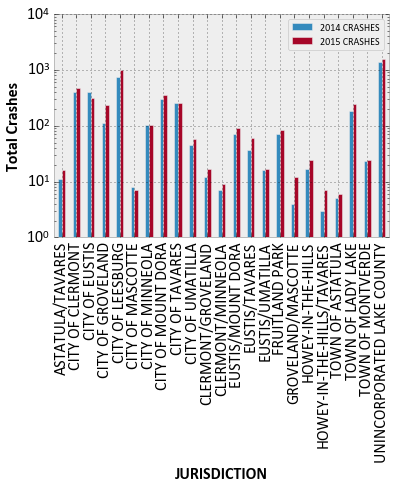

In [6]:
groupArea = lcri2014.groupby(['JURISDICTION'])
citySeg = groupArea[['SEGMENT LENGTH']].aggregate(np.sum)
# cityAADT = groupArea[['AADT']].aggregate(np.sum)
# cityAADT['YEAR T'] = cityAADT * 365.0
cityCrash = groupArea[['2014 CRASHES','2015 CRASHES']].aggregate(np.sum)
cityCrash.plot.bar(stacked=False, log=True)
plt.ylabel('Total Crashes')
plt.legend(prop={'size':10})
plt.show()

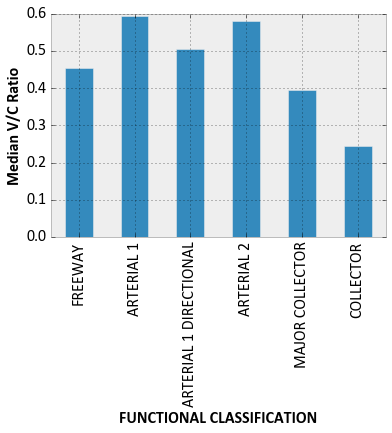

In [7]:
groupFunc = lcri2014.groupby(['FUNCTIONAL CLASSIFICATION'])
funcVC = groupFunc[['MAX VC RATIO']].aggregate(np.nanmedian)
funcVC2 = funcVC.loc[['FREEWAY','ARTERIAL 1','ARTERIAL 1 DIRECTIONAL', 'ARTERIAL 2','MAJOR COLLECTOR','COLLECTOR']] #Sort for plotting
funcVC2.plot.bar(stacked=False, legend=False)
plt.ylabel('Median V/C Ratio')
plt.show()

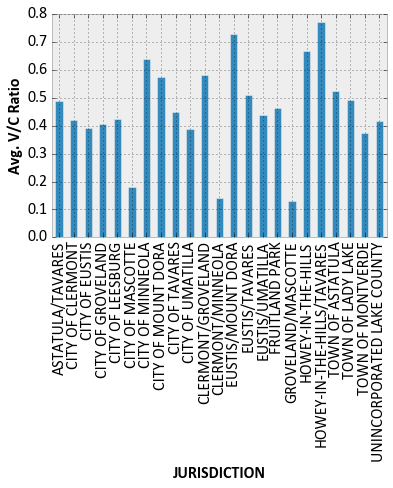

In [8]:
groupCity = lcri2014.groupby(['JURISDICTION'])
cityVC = groupCity[['MAX VC RATIO']].mean()
cityVC.plot.bar(stacked=False, legend=False)
plt.ylabel('Avg. V/C Ratio')
plt.show()

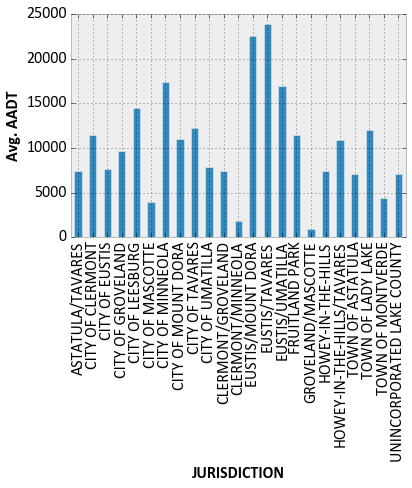

In [9]:
cityVol = groupCity[['AADT']].mean()
cityVol.plot.bar(stacked=False, legend=False)
plt.ylabel('Avg. AADT')
plt.show()

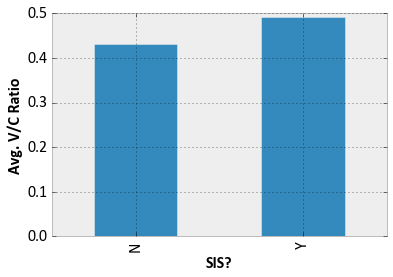

In [10]:
groupFunc = lcri2014.groupby(['SIS?'])
funcVC = groupFunc[['MAX VC RATIO']].mean()
funcVC.plot.bar(stacked=False, legend=False)
plt.ylabel('Avg. V/C Ratio')
plt.show()

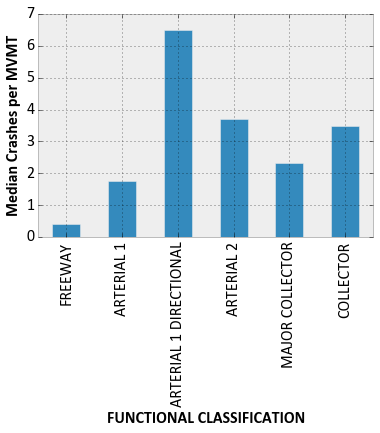

In [11]:
#Saftey Criteria Score
def crashPMVMT(row):
    ans = 0
    #Average 2014 and 2015 Crashes ignoring NaN data points
    crashArr = np.array([row['2014 CRASHES'], row['2015 CRASHES']])
    numCrash = np.nanmean(crashArr)
    segLen = row['SEGMENT LENGTH']
    AADT = row['AADT']
#     crashPerMile = numCrash / segLen
    crashPerVMT = numCrash / ((AADT * 365.0 * segLen)/1000000.0)
    return crashPerVMT    

modlcri2014 = lcri2014.copy()
modlcri2014['Crash Per MVMT'] = modlcri2014.apply(crashPMVMT, axis=1)
# modlcri2014
groupFunc = modlcri2014.groupby(['FUNCTIONAL CLASSIFICATION'])
funcCrash = groupFunc['Crash Per MVMT'].aggregate(np.nanmedian)
funcCrash2 = funcCrash.loc[['FREEWAY','ARTERIAL 1','ARTERIAL 1 DIRECTIONAL','ARTERIAL 2','MAJOR COLLECTOR','COLLECTOR']] #Sort for plotting
funcCrash2.plot.bar(stacked=False, log=False)
plt.ylabel('Median Crashes per MVMT')
# plt.legend(prop={'size':10})
plt.show()

In [14]:
groupFunc.std()

,NUMBER OF LANES,LOS CAPACITY,A,B,C,D,E,AADT,PM PEAK HOUR TOTAL,PEAK HOUR DIRECTION,...,SEGMENT LENGTH,Ex. Volume to MAV,Future-LRTP,Existing Volume,Intermodal/Economic,Evacuation Route,Transit,Safety,Total Score,Crash Per MVMT
FUNCTIONAL CLASSIFICATION,,,,,,,,,,,,,,,,,,,,,
ARTERIAL 1,1.617394,941.300496,0.0,317.771843,931.632320,896.618190,795.513372,11756.158453,947.360999,535.658041,...,1.437661,6.937396,0.920575,3.061788,1.031448,1.719080,3.041316,4.170468,11.776769,7.818370
ARTERIAL 1 DIRECTIONAL,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1140.000376,1002.042263,296.508703,...,0.284753,3.609808,0.000000,0.000000,0.000000,0.000000,0.000000,1.767767,4.874716,2.099451
ARTERIAL 2,1.171893,516.688172,0.0,0.000000,219.781710,516.688172,523.186391,8502.360719,679.459570,364.892441,...,0.411509,5.042529,0.000000,2.273030,0.000000,2.549510,2.533114,4.453463,11.510956,3.598908
COLLECTOR,0.140720,132.266415,0.0,95.667334,117.017766,108.964255,256.006533,3030.212677,268.769458,156.899279,...,1.080428,7.405157,0.992559,0.543647,0.000000,1.034180,0.916775,3.261504,8.789820,20.976460
FREEWAY,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3887.121386,1167.683033,588.449587,...,4.584018,6.179199,0.000000,1.250000,0.000000,0.000000,0.000000,0.000000,6.900725,0.245619
MAJOR COLLECTOR,0.711247,367.295590,0.0,140.515890,357.723948,373.626405,426.232121,4230.450881,355.382813,208.745604,...,1.587356,7.651232,1.552067,1.149408,0.000000,1.714534,1.405725,3.501301,8.591114,7.374069


C:\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


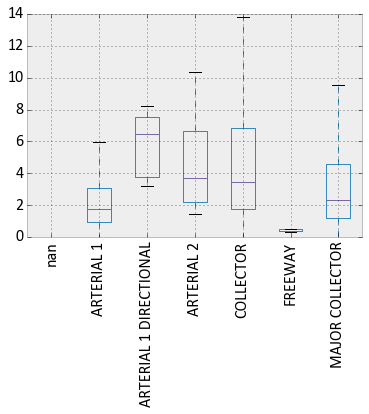

In [12]:
df2 = modlcri2014.pivot(columns = 'FUNCTIONAL CLASSIFICATION', values = 'Crash Per MVMT')
df2.plot.box(showfliers=False)
plt.xticks(rotation='vertical')
plt.show()